# LLM training guide

Learning outcomes:
- pretraining
- causal LM vs masked LM
- inference of an LLM under the hood
- causal LM training

# 🔍 What is pretraining?

Pretraining a language model involves training it from scratch on a large corpus of text. This process enables the model to develop a general understanding of language, grammar, and common knowledge. Pretraining requires a huge amount of data.

In reality, what you will learn in this notebook is continual pre-training.

Continual training, starts with a model that has already been pretrained and further trains it on new, often domain-specific data. This approach adapts the model to new topics or writing styles without losing the general language skills it originally learned.

## Types of language models you can train

There are two types of language modeling, causal and masked. Causal language models are frequently used for text generation whereas masked language models are used for language understanding. Examples: GPT-2 and GPT-3 are causal LMs, BERT is a masked LM.


**So technically, what's the difference?**

- Causal LMs are trained to predict the next token given a sequence. They can only 'observe' the token in the left. We call these models autoregressive.

- Masked LMs are trained to predict a 'masked' token and can attend to both left and right of a sequence.

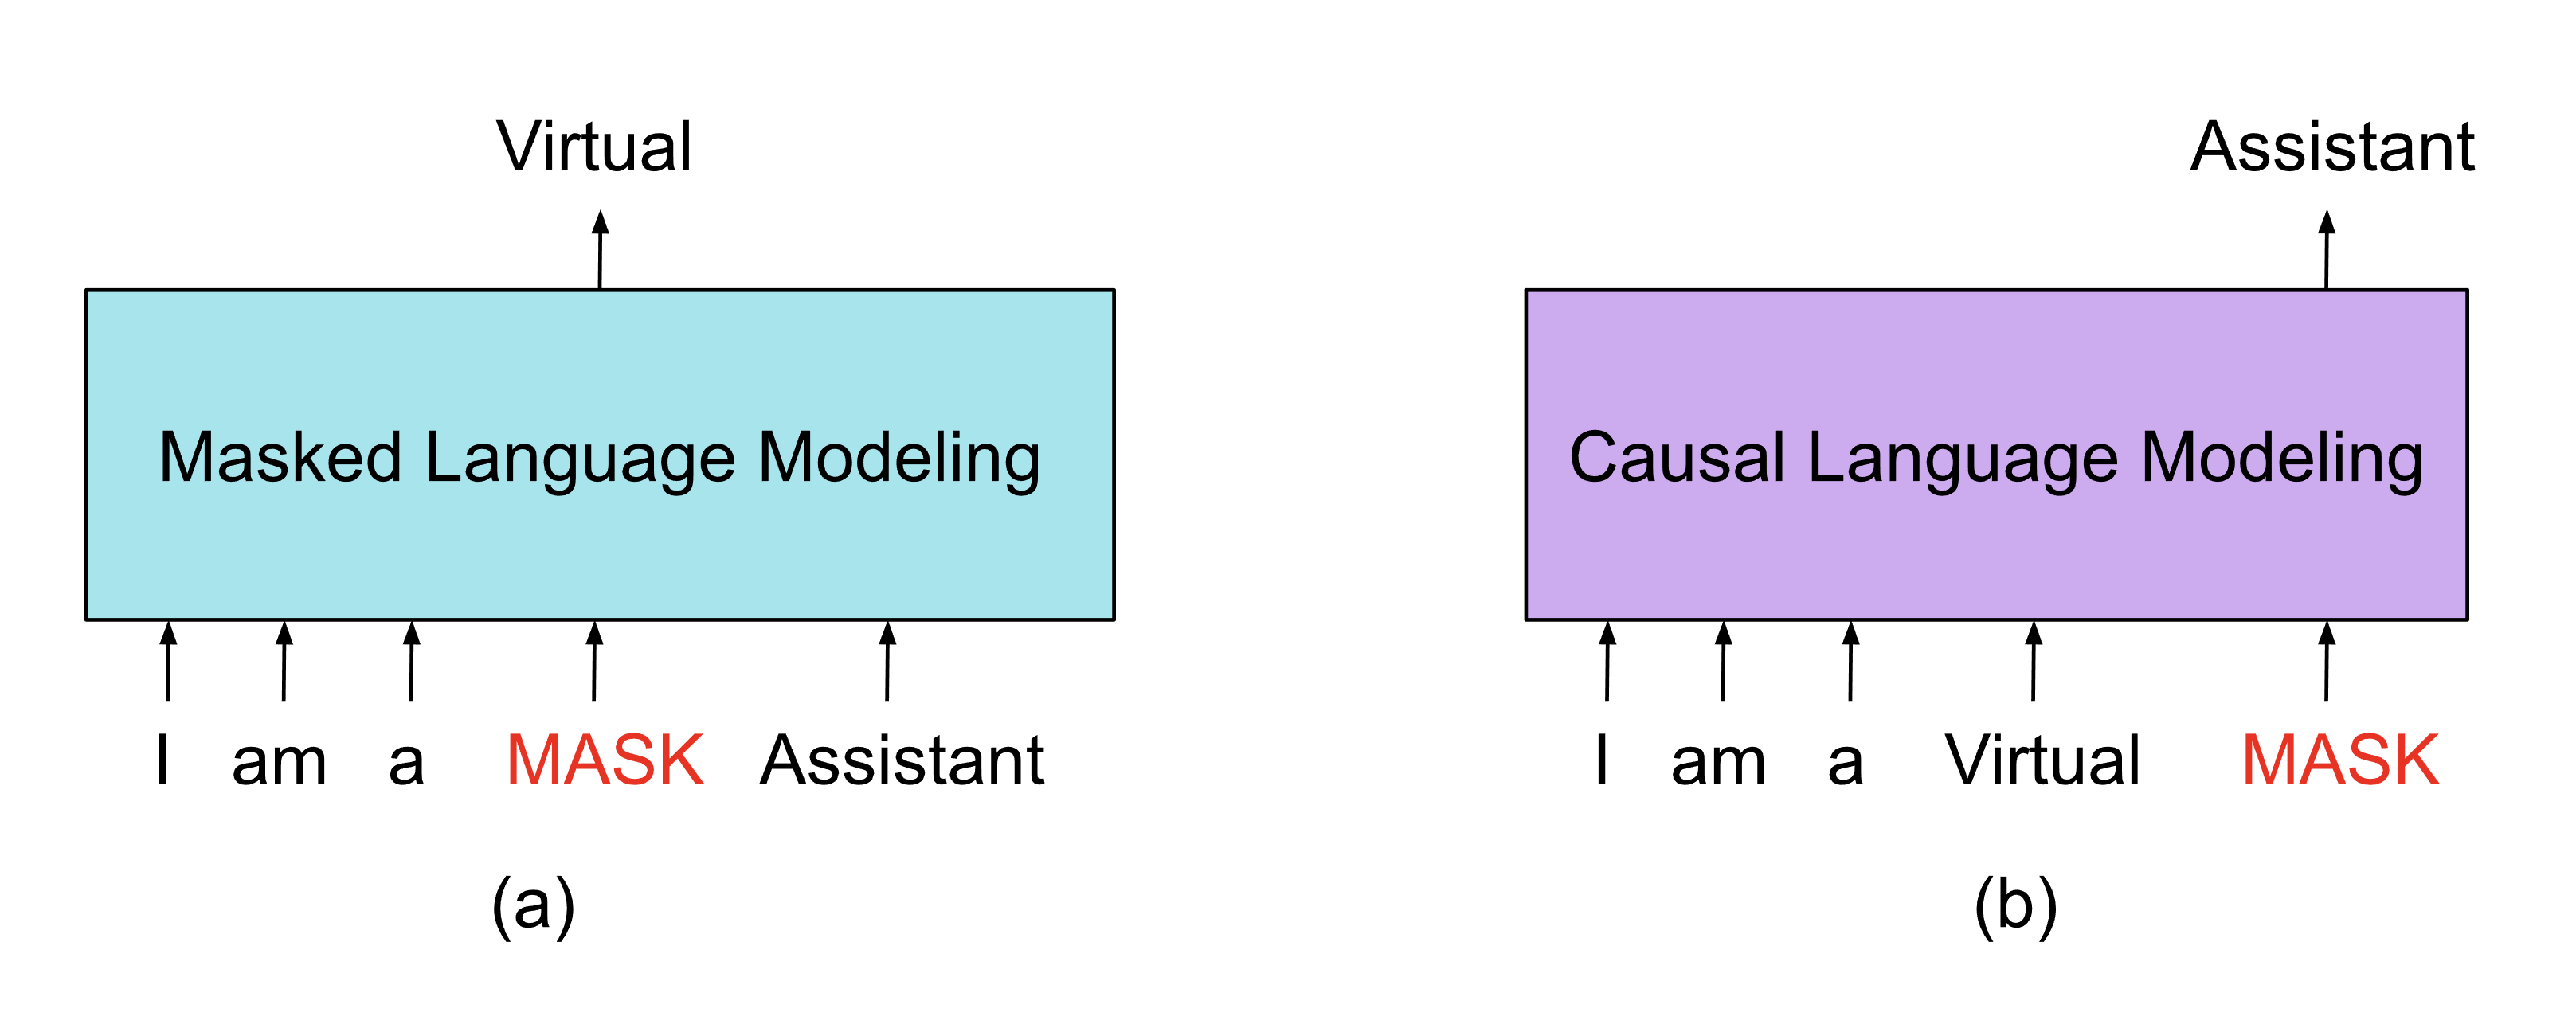

Let's dive deeper into causal language models.

# Causal language models

In the following cells, you will load a model from HuggingFace Hub and run the inference. We chose Qwen3-0.6B, a small CausalLM of 600M parameters.

You can test with other models if you want to 😊.

Before you begin, make sure you have all the necessary libraries installed:

In [ ]:
! uv pip install -q -U datasets wandb
! uv pip install -q --upgrade git+https://github.com/huggingface/transformers.git
! uv pip install -q huggingface_hub[hf_xet]

In [ ]:

model_id = "Qwen/Qwen3-0.6B"

# Load model
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

## Next token prediction

In [ ]:
import torch

# define the sequence for which you want to predict the next tokens
sequence = "I like hackathons because"

# first tokenize your sequence
input_ids = tokenizer(sequence, return_tensors="pt").input_ids

# run the model and get the logits (can be seen as probabilites) of the next tokens
logits = model(input_ids).logits

# get the predicted next token
next_token_logits = logits[:, -1, :]
predicted_token_id = torch.argmax(next_token_logits, dim=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Next token: {predicted_token}")

Next token:  they


As you can see, we provided the sequence "I like hackathons because" and the model predicted "they" as being the next word. The sequence becomes: "I like hackathons because they".

**Explanation:**

- `outputs.logits` contains the raw scores for each token in the vocabulary for each position in the input.

- `logits[:, -1, :]` grabs the logits for the next token after the end of your input sequence.

- `torch.argmax(...)` finds the most likely next token.

- `tokenizer.decode(...)` converts the token ID back to a human-readable string.

We can see what are the top 5 predicted tokens (for the next word).


## Next token prediction under the hood: what are the most probable next tokens?

In [ ]:
import torch.nn.functional as F

# apply softmax to convert logits into probabilities
# to learn about softmax: https://www.datacamp.com/tutorial/softmax-activation-function-in-python
probs = F.softmax(next_token_logits, dim=-1)

# get top 5 predictions
top_k = 5
top_probs, top_indices = torch.topk(probs, top_k, dim=-1)

# decode top tokens
top_tokens = [tokenizer.decode([idx]) for idx in top_indices[0]]
top_probs = top_probs[0].tolist()

print("Top predicted next tokens and their probability:")
for token, prob in zip(top_tokens, top_probs):
    print(f"{token!r}: {prob:.4f} --> {sequence+token}")


Top predicted next tokens:
' they': 0.5342 --> I like hackathons because they
' I': 0.3545 --> I like hackathons because I
' of': 0.0243 --> I like hackathons because of
' the': 0.0142 --> I like hackathons because the
' it': 0.0114 --> I like hackathons because it


## Generate a full sequence

Now that you've seen what happens when predicting the next token, imagine running the same process repeatedly — appending each newly predicted token to the sequence and using that as input for the next prediction. This is essentially what happens under the hood during text generation.

In [ ]:
max_new_tokens = 10
sequence_to_print = sequence

input_ids = tokenizer(sequence, return_tensors="pt").input_ids

# generate tokens one by one: this is called greedy decoding
for _ in range(max_new_tokens):
    outputs = model(input_ids)
    logits = outputs.logits

    # get logits for the last token and pick the most likely next token
    next_token_logits = logits[:, -1, :]
    next_token_id = torch.argmax(next_token_logits, dim=-1)

    # show the predicted sequence
    next_token = tokenizer.decode(next_token_id[0], skip_special_tokens=True)
    sequence_to_print += next_token
    print("-->", sequence_to_print)

    # append the predicted token to the input
    input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=1)

    next_token_logits = logits[:, -1, :]

--> I like hackathons because they
--> I like hackathons because they are
--> I like hackathons because they are a
--> I like hackathons because they are a great
--> I like hackathons because they are a great opportunity
--> I like hackathons because they are a great opportunity to
--> I like hackathons because they are a great opportunity to learn
--> I like hackathons because they are a great opportunity to learn and
--> I like hackathons because they are a great opportunity to learn and grow
--> I like hackathons because they are a great opportunity to learn and grow.


You can also do that by using the 'generate' method.

In [ ]:
input_ids = tokenizer(sequence, return_tensors="pt").input_ids

outputs = model.generate(input_ids, max_new_tokens=10)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("Generated text: ", generated_text[0])

Generated text:  I like hackathons because they're fun and provide an opportunity to learn new


Notice how the generated text is different from the previous output. What explains this in your opinion?

# 🚀 Train your first causalLM
For this, we will use Atlaset dataset from AtlasIA.

## Load your dataset

In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset

In [ ]:
dataset_id = "atlasia/atlaset"
ds = load_dataset(dataset_id, split="train[:10000]") # for time and memory constraints, we will pick only 10k sentences from the dataset
ds

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00005.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00001-of-00005.parquet:   0%|          | 0.00/148M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00002-of-00005.parquet:   0%|          | 0.00/95.2M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00003-of-00005.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00004-of-00005.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/218k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1171515 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2683 [00:00<?, ? examples/s]

Dataset({
    features: ['dataset_source', 'text', 'metadata', 'token_count', 'word_count'],
    num_rows: 10000
})

First try the base model on a darija sentence from the train data before training it.

In [ ]:
# you will only need the column content to train your model
ds = ds.select_columns(["text"])
ds.to_pandas().head()

,text
0,التقريب أكثر من نص مصاريف المخزن كانت كتمشي لب...
1,ماهي عواقب مصاريف المخزن على الاقتصاد المغربي؟
2,نفقات المخزن أدت إلى تدهور الاقتصاد المغربي، ح...
3,في تسعينيات القرن التاسع عشر، طالبت الإدارة وا...
4,ما كانو الأسباب الرئيسية اللي دفعو فرنسا باش ت...


In [ ]:
sequence = ' '.join(ds[0]['text'].split()[1:10])
print(sequence)

In [ ]:
input_ids = tokenizer(sequence, return_tensors="pt").input_ids

outputs = model.generate(input_ids, max_new_tokens=10)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("Generated text: ", generated_text[0])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text:  أكثر من نص مصاريف المخزن كانت كتمشي لبرا باشيني بس نحن نحتاج للا


As you can see, the generated text is completely nonsensical. Let's see if we can make the model understand Darija 👀

## Preprocess

In [ ]:
# split to train and test datasets for evaluation
data_splits = ds.train_test_split(test_size=0.2,seed=42)
data_splits

DatasetDict({
    train: Dataset({
        features: ['dataset_source', 'text', 'metadata', 'token_count', 'word_count'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['dataset_source', 'text', 'metadata', 'token_count', 'word_count'],
        num_rows: 2000
    })
})

### Tokenize

You learned what tokenization is and why it's crucial before training any LM. Now you will apply it on the dataset.

An important parameter to take into account before training is the `context length`. It should be less than or equal the `model_max_length`.
- A large `context length` means more context and more GPU memory (because your input sequences will be longer) and vice-versa.
- We will set it to 256 for this example (recent LLMs have more than 1M context length 😅).
- For this, we will need to truncate our training sequences to fit the context length.

In [ ]:
context_length = 256

def tokenize(examples):
  results = tokenizer(
      examples["text"],
      truncation=True,
      max_length=context_length,
      return_overflowing_tokens=True, # used so that if a text is longer than the context_length, it gets split into multiple chunks instead of being truncated. This ensures that all parts of the text are included in training.

  )
  input_batch = []
  for l, input_ids in zip(results["length"], results["input_ids"]):
    if l <= context_length:
      input_batch.append(input_ids)

  return {"input_ids":input_batch}

In [ ]:
tokenized_ds = data_splits.map(tokenize, batched=True, remove_columns=data_splits["train"].column_names)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 8054
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 2020
    })
})

In [ ]:
tokenized_ds['train'].to_pandas().head()

,input_ids
0,"[126409, 129132, 128420, 124172, 124104, 25871..."
1,"[126267, 32790, 123904, 130643, 45577, 124641,..."
2,"[31382, 123897, 125040, 65398, 129688, 140019,..."
3,"[31382, 8532, 123897, 56794, 124232, 14293, 12..."
4,"[129786, 124210]"


### Datacollator

The last step in data preprocessing is to generate batches and labels. Batches are used to process data in chunks, enabling faster computation, stable gradient estimates, and better use of memory during model training. Labels are necessary because the training is based on learning to predict the next word (note that we don't need to annotate anything).

To do this, we will use `DataCollatorForLanguageModeling`. Here's what it does:



* Create batches
* Add padding to batches (inputs are dynamically padded to the maximum length of a batch if they are not all of the same length)
* Create labels: for causal language modeling (our case), it sets the input and label to be the same, with the model learning to predict the next token in the sequence


<center>

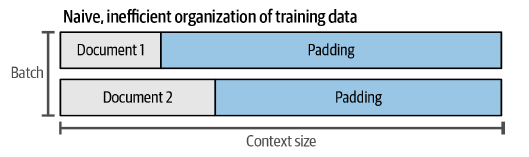
</center>


<center>

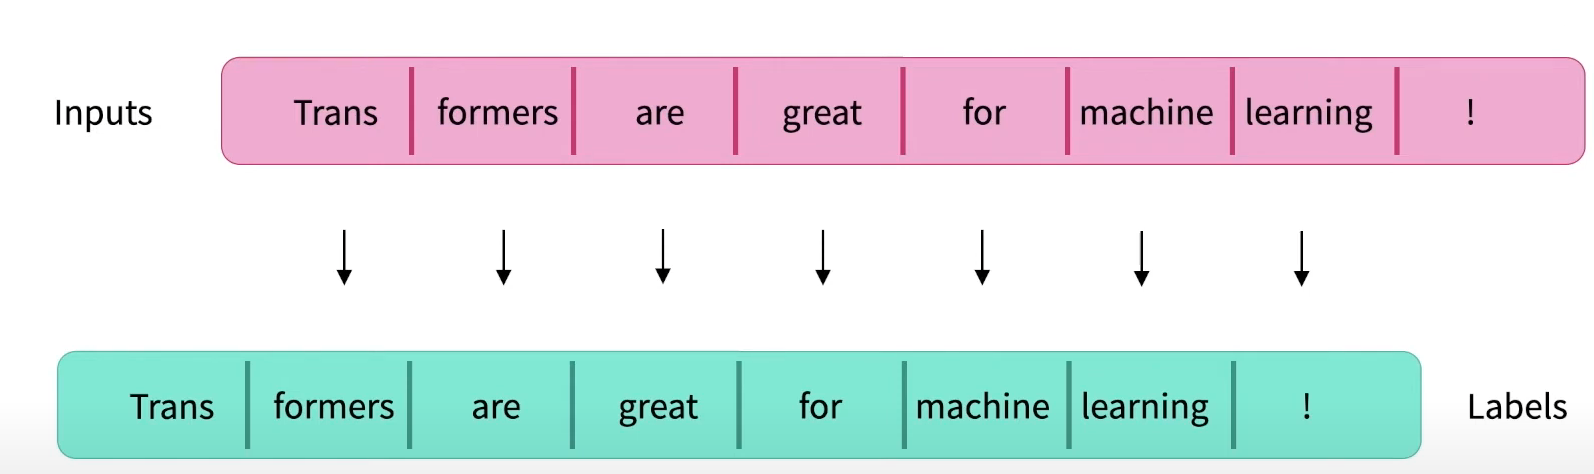

</center>


In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # mlm is masked language modeling, we sit it to false beause we're training a causal language model

## Train

For demonstration purposes, we chose underoptimal hyperparameters to make the training fast.

Some core concepts to check:
- batch size
- learning rate
- lr scheduler
- epoch vs step

You will need to setup a wandb account to log your training and eval metrics: https://wandb.ai/site/.
Weights and Biases is an experiment tracking and monitoring platform widely used in model training.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="test_dir",
    num_train_epochs=1,
    per_device_eval_batch_size=1,
    per_device_train_batch_size=1,
    learning_rate=5e-4,
    warmup_steps=10,
    lr_scheduler_type="linear",
    save_steps=100,
    save_total_limit=2,
    fp16=True,
    logging_steps=2,
    push_to_hub=False,
    gradient_accumulation_steps=16, # allows simulation of a larger batch size by accumulating gradients over several steps before performing a model update - consumes less GPU memory
    max_steps = 1000, # for time constraints, we stop at step 1000 (less than 1 epoch)
    report_to="wandb",
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
)

<ipython-input-22-216a7ec52edb>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: imane-mo07 (imane-mo-atlasia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
2,4.725400
4,5.056900
6,4.555000
8,4.535100
10,4.274800
12,4.100500
14,3.870200
16,3.982200
18,3.958900
20,3.989600


TrainOutput(global_step=100, training_loss=4.672100539207459, metrics={'train_runtime': 896.7684, 'train_samples_per_second': 1.784, 'train_steps_per_second': 0.112, 'total_flos': 92302598209536.0, 'train_loss': 4.672100539207459, 'epoch': 0.19865905140302956})

In [ ]:
input_ids = tokenizer(sequence, return_tensors="pt").input_ids.to(model.device)

outputs = model.generate(input_ids, max_new_tokens=10)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("Generated text: ", generated_text[0])

Generated text:  أكثر من نص مصاريف المخزن كانت كتمشي لبرا باش ييغني في 1056،


As you can see, the text generated with the trained model is more relevant than the one generated by the base one. This shows improvement over the base model in the specific context, even though generalization remains weak (as our model is likely overfitting because of the small training dataset and underoptimal hyperparams). In real scenarios, extended training on diverse data and optimizing hyperparams is required for robust performance.

# Mini-challenge

Answer the following questions:
- explain the loss and how it's computed in this case (try to compute it with code)
- propose a method to evaluate the model